## Environment Setup

In [ ]:
%%shell
gdown --quiet 1-IeoZDwT5wQzBUpsaS5B6vTaP-2ZBkam
pip --quiet install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import pandas as pd
np_arr = np.load('drive/MyDrive/NYU 2023 Spring/AdvancedPython/output/reduced_tfidf.npy')
pd_df = pd.DataFrame(np_arr)

In [ ]:
pd_df.shape

(8230, 100)

In [ ]:
import pyspark
from pyspark.sql import SparkSession

sc = pyspark.SparkContext.getOrCreate()
spark = SparkSession.builder.appName('Pandas to Spark').getOrCreate()
spark

In [ ]:
# pd_sample = pd_df.sample(100)
# spark_sample = spark.createDataFrame(pd_sample)
# spark_sample.show(5)

In [ ]:
spark_df = spark.createDataFrame(pd_df)

In [ ]:
spark_df.show(5)

+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------

## Format the Data

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# Select features for clustering
vec_assembler = VectorAssembler(inputCols = spark_df.columns, outputCol='features')
final_data = vec_assembler.transform(spark_df)

In [ ]:
final_data.show(5)

+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------

In [ ]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

In [ ]:
# Normalize each feature to have unit standard deviation.
final_data = scalerModel.transform(final_data)

## Training the Model and Evaluate

In [ ]:
from pyspark.ml.clustering import KMeans, KMeansModel

# Training a k-means model.
kmeans = KMeans(featuresCol='scaledFeatures',k=4)
model = kmeans.fit(final_data)
predictions = model.transform(final_data)

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

# evaluate the clustering performance
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.1555293558072894


In [ ]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

In [ ]:
model.transform(final_data).select('prediction').show()

+----------+
|prediction|
+----------+
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         1|
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         1|
|         2|
|         1|
|         2|
|         2|
|         2|
|         2|
+----------+
only showing top 20 rows



In [ ]:
kmeans_cluster = model.transform(final_data).select('prediction')
kmeans_cluster.show(10)

+----------+
|prediction|
+----------+
|         2|
|         2|
|         2|
|         2|
|         2|
|         2|
|         1|
|         2|
|         2|
|         2|
+----------+
only showing top 10 rows



In [ ]:
kmeans_cluster.count()

8230

In [ ]:
import numpy as np

# extract the 'prediction' column from the DataFrame and convert it to a NumPy array
cluster_labels = np.array(kmeans_cluster.select('prediction').rdd.flatMap(lambda x: x).collect())

# output the NumPy array to a CSV file
np.savetxt('cluster.csv', cluster_labels, delimiter=',', header='Cluster Label', comments='')


## Compare the Silhouette scores for K-means models with k values ranging from 1 to 10 

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# assuming your preprocessed training and testing datasets are stored in the variables 'train_data' and 'test_data'
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(k=k, seed=1)
    model = kmeans.fit(final_data)
    predictions = model.transform(final_data)
    evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette')
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)

In [ ]:
silhouette_scores

[0.14456669849298953,
 0.15168107874274475,
 0.2684918951703843,
 0.10743936418366595,
 0.09816691643483891,
 0.19606860986140193,
 0.16951961993035636,
 0.11235876570883709,
 0.006278350122325023]

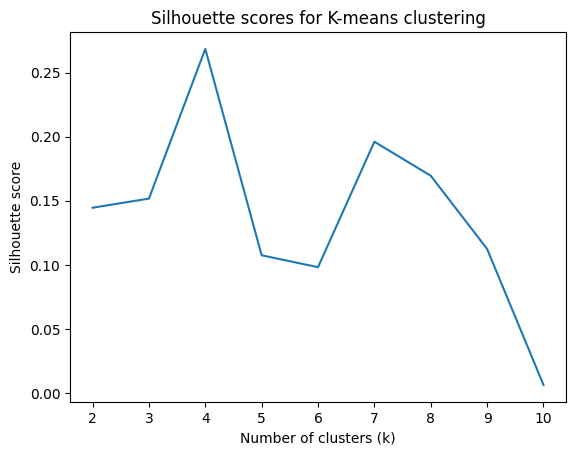

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import array, lit, udf
from pyspark.sql.types import ArrayType, DoubleType, FloatType

# define a UDF that converts an array of doubles to float
def array_to_float(arr):
    return float(arr[0])

udf_array_to_float = udf(array_to_float, FloatType())

df = spark.createDataFrame(pd.DataFrame({'k': range(2, 11)}))
df = df.withColumn('silhouette_score', udf_array_to_float(array([lit(score) for score in silhouette_scores])))
df_pd = df.toPandas()

plt.plot(df_pd['k'], silhouette_scores)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores for K-means clustering')
plt.show()

In [ ]:
silhouette_scores

[0.14456669849298953,
 0.15168107874274475,
 0.2684918951703843,
 0.10743936418366595,
 0.09816691643483891,
 0.19606860986140193,
 0.16951961993035636,
 0.11235876570883709,
 0.006278350122325023]

To choose the optimal value of k, you can use the Silhouette score to evaluate the performance of the clustering algorithm for different values of k. The Silhouette score measures how similar an object is to its own cluster compared to other clusters. A higher Silhouette score indicates better clustering performance.
To present the Silhouette score results, you can create a line plot with k on the x-axis and Silhouette score on the y-axis. Here's an example code snippet that demonstrates how to create the plot using matplotlib:

In [ ]:
# silhouette_scores is the list of Silhouette scores for each k value

# find the index of the maximum Silhouette score
best_k_index = np.argmax(silhouette_scores)

# add 2 to the index to get the best k value (since k starts from 2)
best_k = best_k_index + 2

print(f"The best k value is: {best_k}")

The best k value is: 4
